# Predict Response of JIA Patients to Methotrexate (KFold Cross Validation)

In this notebook, we use the dataset [GSE81259](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81259) to predict response status to methotrexate of 47 JIA (juvenile idiopathic arthritis) patients by applying XGBoost (eXtreme Gradient Boosting) using KFold cross validation.

The datasets also includes samples from 14 age-matched controls.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in clinical data and remove control samples
clin = pd.read_csv('data/GSE81259_clin_pub.csv', index_col = 0, header = 0)
clin = clin[clin['JIA_control'] != 'control']
clin.head()

,GEO GSM file ID,JIA_control,response_status
GEO ID,,,
JIA1,GSM2147667,JIA,RESP
JIA2,GSM2147668,JIA,NON-RESP
JIA3,GSM2147669,JIA,RESP
JIA4,GSM2147670,JIA,NON-RESP
JIA5,GSM2147671,JIA,RESP


In [3]:
# list of sample ids from column 'GEO GSM file ID' in clin
sample_ids = clin['GEO GSM file ID'].tolist()   
sample_ids

['GSM2147667',
 'GSM2147668',
 'GSM2147669',
 'GSM2147670',
 'GSM2147671',
 'GSM2147672',
 'GSM2147673',
 'GSM2147674',
 'GSM2147675',
 'GSM2147676',
 'GSM2147677',
 'GSM2147678',
 'GSM2147679',
 'GSM2147680',
 'GSM2147681',
 'GSM2147682',
 'GSM2147683',
 'GSM2147684',
 'GSM2147685',
 'GSM2147686',
 'GSM2147687',
 'GSM2147688',
 'GSM2147689',
 'GSM2147690',
 'GSM2147691',
 'GSM2147692',
 'GSM2147693',
 'GSM2147694',
 'GSM2147695',
 'GSM2147696',
 'GSM2147697',
 'GSM2147698',
 'GSM2147699',
 'GSM2147700',
 'GSM2147701',
 'GSM2147702',
 'GSM2147703',
 'GSM2147704',
 'GSM2147705',
 'GSM2147706',
 'GSM2147707',
 'GSM2147708',
 'GSM2147709',
 'GSM2147710',
 'GSM2147711',
 'GSM2147712',
 'GSM2147713']

In [4]:
# read in gene expression data and select and order the columns according to the sample_ids
data = pd.read_csv('data/GSE81259_PBMCarray.csv', index_col = 0, header = 0)
data = data[sample_ids]
data = data.T
data.head()



REF_ID,A1BG,ADA,CDH2,AKT3,GAGE12F,ZBTB11-AS1,MED6,NAALAD2,SNORD116-4,SNORD116-17,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,DGCR2,CASP8AP2,SCO2
GSM2147667,2.230262,4.287502,0.047112,2.696277,0.178127,2.051724,2.798878,0.760231,2.433349,1.033955,...,3.141504,6.467445,4.890767,3.708914,0.177147,4.533478,4.555939,4.378236,3.353766,5.962857
GSM2147668,2.076718,4.474807,0.231723,2.775313,0.121893,2.031543,2.775456,0.713071,2.116577,0.260178,...,3.388239,6.453457,4.831991,3.766517,0.327388,4.472643,4.387697,4.400673,3.347360,5.787106
GSM2147669,1.975005,4.881003,0.080278,2.271523,0.134423,1.872452,2.642762,0.663850,1.706486,0.635094,...,3.232520,6.553724,4.787105,3.757750,0.323556,4.288318,4.362412,4.238898,3.001191,6.422034
GSM2147670,2.405182,4.092159,0.025810,2.461102,0.135417,1.671465,2.617314,0.788595,2.034374,1.395815,...,3.540687,6.637830,4.761604,3.778179,0.091794,4.582637,4.560620,4.494842,2.919715,6.622172
GSM2147671,2.334368,4.323202,0.146190,2.483901,0.127919,1.782502,2.553282,0.757331,1.923689,0.951622,...,3.219133,6.628804,4.778759,3.841521,0.186310,4.439802,4.367744,4.398966,2.816094,6.542689


In [5]:
# in clin, create a new column for response
# assign 1 to samples with 'RESP' in 'response_status' column and 0 to samples with 'NON-RESP'
clin['response'] = np.where(clin['response_status'] == 'RESP', 1, 0)
clin.head()

,GEO GSM file ID,JIA_control,response_status,response
GEO ID,,,,
JIA1,GSM2147667,JIA,RESP,1
JIA2,GSM2147668,JIA,NON-RESP,0
JIA3,GSM2147669,JIA,RESP,1
JIA4,GSM2147670,JIA,NON-RESP,0
JIA5,GSM2147671,JIA,RESP,1


## PCA and t-SNE plots

In [6]:
# Scale the data for PCA and t-SNE
data_scaled = StandardScaler().fit_transform(data)

In [7]:
# Prepare the first 2 PCA components and plot
pca_2c = PCA(n_components = 2)
pca_2c_features = pca_2c.fit_transform(data_scaled)

pca_2c_df = pd.DataFrame(
    data = pca_2c_features, 
    columns = ['PC1', 'PC2'])

target = list(clin['response'])

pca_2c_df['target'] = target

expl_var = round(sum(pca_2c.explained_variance_ratio_) * 100, 2)

pca1_expl_var = round(pca_2c.explained_variance_ratio_[0] * 100, 2)
pca2_expl_var = round(pca_2c.explained_variance_ratio_[1] * 100, 2)

x_title = "PC1 (" + str(pca1_expl_var) + "%)"
y_title = "PC2 (" + str(pca2_expl_var) + "%)"

sub_title = "(Explained variance for PC1 and PC2 : " + str(expl_var) + "%)"
title = "PCA Plot \n" + sub_title

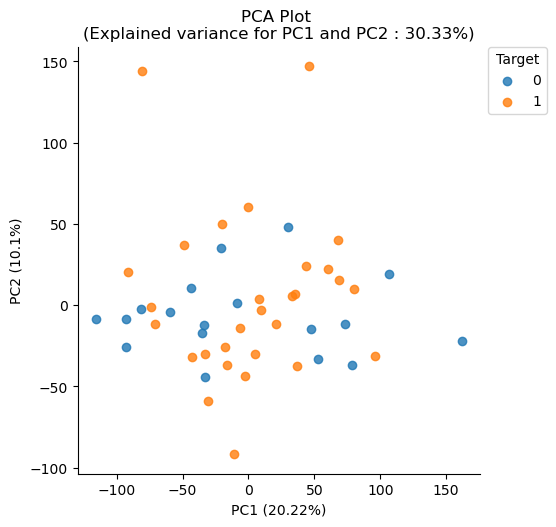

In [8]:
# Plot the first 2 PCA components

sns.lmplot(
    x = 'PC1', 
    y = 'PC2',
    data = pca_2c_df,
    hue = 'target',
    fit_reg = False,
    legend = False
)
plt.title(title)
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'Target')
plt.xlabel(x_title)
plt.ylabel(y_title)
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


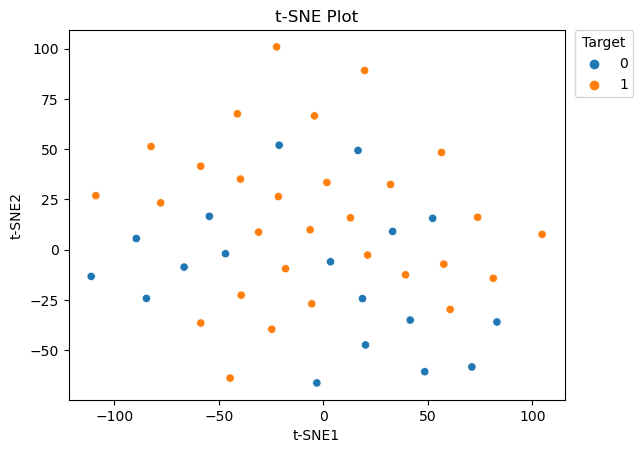

In [9]:
# t-SNE plot
tsne = TSNE(random_state=0)
tsne_results = tsne.fit_transform(data_scaled)
tsne_results = pd.DataFrame(tsne_results, columns = ['t-SNE1', 't-SNE2'])
tsne_results['target'] = target

sns.scatterplot(data = tsne_results, 
                x = "t-SNE1", 
                y = "t-SNE2",
                hue = 'target',
                legend = True
               )
plt.title('t-SNE Plot')
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'Target')
plt.show()

## Train the model

In [10]:
# Assign response, and load data
y =  clin["response"]
X = data

In [11]:
# Parameters for the XGBoost model
param = {
    'max_depth': 4,                       # This has to be optimized for your model
    'eta': 0.1,                           # This has to be optimized for your model
    'objective': 'binary:logistic',       # This depends on the nature of your model
    'eval_metric': 'auc'                  # This depends on the objective
}

num_round = 100  # Number of rounds for boosting

# Convert the data into DMatrix format
dtrain = xgb.DMatrix(X, label=y)

# Define k-fold cross-validation with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=132)

# Arrays to store the evaluation metrics for each fold
accuracies = []
f1_scores = []
precisions = []
recalls = []
roc_aucs = []
confusion_matrices = []


In [12]:
# Cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    progress = {}
    
    model = xgb.train(param, dtrain, num_round, 
                      evals=evallist, evals_result=progress, 
                      verbose_eval=10, 
                      early_stopping_rounds=25)
 
    # Generate predictions for the test fold
    preds = model.predict(dtest)
    predictions = [1 if i >= 0.5 else 0 for i in preds]
    
    # Evaluate the model
    accuracies.append(accuracy_score(y_test, predictions))
    f1_scores.append(f1_score(y_test, predictions))
    precisions.append(precision_score(y_test, predictions))
    recalls.append(recall_score(y_test, predictions))
    roc_aucs.append(roc_auc_score(y_test, predictions))
    confusion_matrices.append(confusion_matrix(y_test, predictions))



[0]	eval-auc:0.45833	train-auc:0.99224
[10]	eval-auc:0.20833	train-auc:1.00000
[20]	eval-auc:0.29167	train-auc:1.00000
[30]	eval-auc:0.33333	train-auc:1.00000
[33]	eval-auc:0.33333	train-auc:1.00000
[0]	eval-auc:0.25000	train-auc:0.95387
[10]	eval-auc:0.15625	train-auc:1.00000
[20]	eval-auc:0.18750	train-auc:1.00000
[30]	eval-auc:0.18750	train-auc:1.00000
[32]	eval-auc:0.18750	train-auc:1.00000
[0]	eval-auc:0.06250	train-auc:0.99580
[10]	eval-auc:0.50000	train-auc:1.00000
[20]	eval-auc:0.37500	train-auc:1.00000
[26]	eval-auc:0.37500	train-auc:1.00000
[0]	eval-auc:0.30000	train-auc:0.98308
[10]	eval-auc:0.30000	train-auc:1.00000
[20]	eval-auc:0.35000	train-auc:1.00000
[26]	eval-auc:0.30000	train-auc:1.00000
[0]	eval-auc:0.33333	train-auc:0.97436
[10]	eval-auc:0.33333	train-auc:1.00000
[20]	eval-auc:0.33333	train-auc:1.00000
[30]	eval-auc:0.27778	train-auc:1.00000
[31]	eval-auc:0.33333	train-auc:1.00000


## Model performance

In [13]:
# Print evaluation metrics
print("Accuracy: %.3f" % np.mean(accuracies))
print("F1 Score: %.3f" % np.mean(f1_scores))
print("Precision: %.3f" % np.mean(precisions))
print("Recall: %.3f" % np.mean(recalls))
print("ROC AUC: %.3f" % np.mean(roc_aucs))


Accuracy: 0.422
F1 Score: 0.579
Precision: 0.559
Recall: 0.708
ROC AUC: 0.379


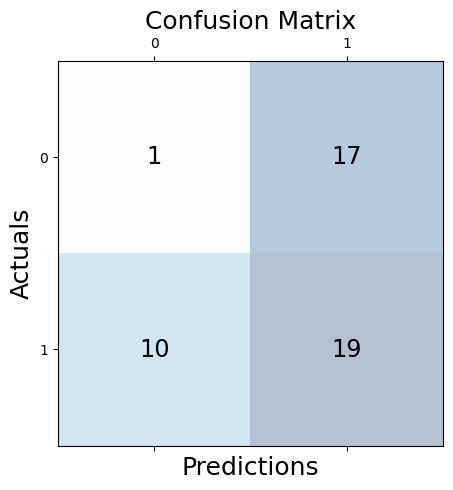

In [14]:
# Print the confusion matrix
conf_matrix = sum(confusion_matrices)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()